In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

C:\Users\Junya\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load Data

In [2]:
train_set = pd.read_csv('./cs-training.csv', index_col=0)
test_set = pd.read_csv('./cs-test.csv', index_col=0)
sample = pd.read_csv('./sampleEntry.csv', index_col=0)
data_dict = pd.read_excel('./Data Dictionary.xls', header=1)

In [3]:
data_dict

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


# 2. Data Processing

## 2.1 Fill Nan

In [4]:
for col in train_set.columns:
    train_set.loc[:, col] = train_set[col].fillna(train_set[col].mean())
    test_set.loc[:, col] = test_set[col].fillna(test_set[col].mean())

In [5]:
train_set.isna().all()

SeriousDlqin2yrs                        False
RevolvingUtilizationOfUnsecuredLines    False
age                                     False
NumberOfTime30-59DaysPastDueNotWorse    False
DebtRatio                               False
MonthlyIncome                           False
NumberOfOpenCreditLinesAndLoans         False
NumberOfTimes90DaysLate                 False
NumberRealEstateLoansOrLines            False
NumberOfTime60-89DaysPastDueNotWorse    False
NumberOfDependents                      False
dtype: bool

## 2.2 Normalization

In [6]:
for col in train_set.columns[1:]:
#     ceil = train_set[col].quantile(0.975)
#     floor = train_set[col].quantile(0.025)
#     train_set.loc[train_set[col]>ceil, col] = ceil
#     train_set.loc[train_set[col]<floor, col] = floor
#     ceil = test_set[col].quantile(0.975)
#     floor = test_set[col].quantile(0.025)
#     test_set.loc[test_set[col]>ceil, col] = ceil
#     test_set.loc[test_set[col]<floor, col] = floor
    train_set.loc[:, col] = (train_set[col] - train_set[col].mean()) / train_set[col].std()
    test_set.loc[:, col] = (test_set[col] - test_set[col].mean()) / test_set[col].std()

In [7]:
train_set

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,-0.021150,-0.493858,0.376592,-0.172833,1.901936e-01,0.883654,-0.063793,4.409531,-0.057852,1.129383
2,0,-0.020385,-0.832339,-0.100419,-0.173167,-3.160000e-01,-0.865294,-0.063793,-0.901280,-0.057852,0.220626
3,0,-0.021582,-0.967732,0.138087,-0.173185,-2.816844e-01,-1.253949,0.176055,-0.901280,-0.057852,-0.688131
4,0,-0.023281,-1.509302,-0.100419,-0.173209,-2.616541e-01,-0.670966,-0.063793,-0.901280,-0.057852,-0.688131
5,0,-0.020585,-0.223073,0.138087,-0.173215,4.418929e+00,-0.282311,-0.063793,-0.016145,-0.057852,-0.688131
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,-0.024055,1.469333,-0.100419,-0.173116,-3.548186e-01,-0.865294,-0.063793,-0.016145,-0.057852,-0.688131
149997,0,-0.023017,-0.561554,-0.100419,-0.172875,-8.433103e-02,-0.865294,-0.063793,-0.016145,-0.057852,1.129383
149998,0,-0.023232,0.386193,-0.100419,1.725863,-3.083560e-13,1.855292,-0.063793,-0.016145,-0.057852,-0.688131
149999,0,-0.024217,-1.509302,-0.100419,-0.173227,-7.408294e-02,-0.865294,-0.063793,-0.901280,-0.057852,-0.688131


# 3. Feature Selection

In [8]:
train_x = train_set.iloc[:, 1:].values
train_y = train_set.iloc[:, 0].values

In [9]:
fs = LogisticRegression(penalty='l1', C=8.0e-4, solver='liblinear')

In [10]:
fs.fit(train_x, train_y)

LogisticRegression(C=0.0008, penalty='l1', solver='liblinear')

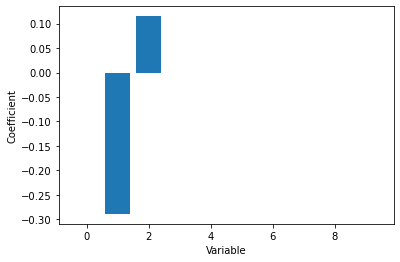

In [11]:
plt.bar(range(train_set.shape[1]-1), fs.coef_[0, :])
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

Selected 2 Features 

In [12]:
val_f = train_set.columns[1:][np.where(np.abs(fs.coef_[0, :])>0.05)]
print(list(val_f))

['age', 'NumberOfTime30-59DaysPastDueNotWorse']


# 4. Prediction

In [13]:
train_x = train_set.loc[:, val_f].values
train_y = train_set.iloc[:, 0].values
test_x = test_set.loc[:, val_f].values
test_y = test_set.iloc[:, 0].values

In [14]:
kf = KFold(n_splits=5)
kf.get_n_splits(train_x)

5

## 4.1 LR

In [15]:
predictor_lr = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [16]:
res_lr = pd.Series(data=None, index=[1e-4, 1e-3, 1e-2, 0.1, 0.5, 1], dtype='object') 
for c in [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1]:
    predictor_lr.set_params(C=c)
    res = list()
    for i, (train_idx, test_idx) in enumerate(kf.split(train_x)):
        predictor_lr.fit(train_x[train_idx, :], train_y[train_idx])
        y_pred = predictor_lr.predict(train_x[test_idx, :])
        res.append(accuracy_score(y_pred, train_y[test_idx]))
    res_lr.loc[c] = np.mean(res)

In [17]:
res_lr

0.0001     0.93316
0.0010    0.933247
0.0100    0.933327
0.1000    0.933327
0.5000    0.933327
1.0000    0.933327
dtype: object

## 4.2 Decision Tree

In [18]:
predictor_tree = DecisionTreeClassifier(criterion='gini', random_state=0)

In [19]:
res_tree = pd.Series(data=None, index=[2, 3, 4, 5, 6, 10], dtype='object') 
for d in [2, 3, 4, 5, 6, 10]:
    predictor_tree.set_params(max_depth=d)
    res = list()
    for i, (train_idx, test_idx) in enumerate(kf.split(train_x)):
        predictor_tree.fit(train_x[train_idx, :], train_y[train_idx])
        y_pred = predictor_tree.predict(train_x[test_idx, :])
        res.append(accuracy_score(y_pred, train_y[test_idx]))
    res_tree.loc[d] = np.mean(res)

In [20]:
res_tree

2      0.93316
3      0.93316
4     0.932933
5      0.93314
6     0.933527
10      0.9331
dtype: object

## 4.3 SVM 

In [21]:
predictor_svm = svm.SVC(gamma='auto', random_state=0, max_iter=500)

In [22]:
res_svm = pd.Series(data=None, index=[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1], dtype='object') 
for c in [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]:
    print(c)
    predictor_svm.set_params(C=c)
    res = list()
    for i, (train_idx, test_idx) in enumerate(kf.split(train_x)):
        predictor_svm.fit(train_x[train_idx, :], train_y[train_idx])
        y_pred = predictor_svm.predict(train_x[test_idx, :])
        res.append(accuracy_score(y_pred, train_y[test_idx]))
    res_svm.loc[c] = np.mean(res)

0.0001


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

0.001


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

0.01


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

0.1


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

0.5


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

1


C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Junya\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

In [23]:
res_svm

0.0001    0.231507
0.0010    0.231507
0.0100    0.231507
0.1000    0.231507
0.5000    0.231507
1.0000    0.231507
dtype: object

# 4. Visualization 

In [24]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')     

In [25]:
predictor_lr = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')
predictor_lr.fit(train_x, train_y)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

C:\Users\Junya\AppData\Local\Temp/ipykernel_20156/2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


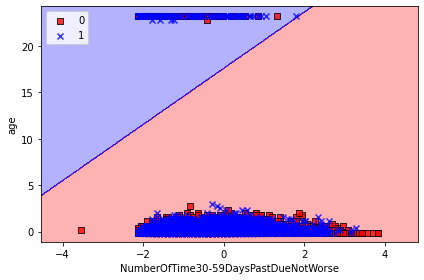

In [26]:
plot_decision_regions(X=train_x, y=train_y, classifier=predictor_lr)
plt.xlabel(f'{val_f[1]}')
plt.ylabel(f'{val_f[0]}')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()